# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [2]:
import numpy as np
import pandas as pd
import re
import os.path
import glob
from parse_results import process_results_xml

In [3]:
target_dir = 'OneDrive//Results - PowerEdge'
bios_setting_file = 'test_settings.csv'
cpu_metrics_dir = 'cpu_data'

In [3]:
metrics_data = pd.DataFrame()
test_details = pd.DataFrame()
scores = pd.DataFrame()

for f in glob.glob(f'{target_dir}//**//results.xml', recursive=True):
    try:
        # Name of test directory -- sert-xxxx
        test_name = os.path.basename(os.path.dirname(f))
        
        if os.path.isfile(f'{target_dir}//{test_name}//invalid.png'):
            print(test_name, ': INVALID RESULT')
            continue
        
        metrics, score, env = process_results_xml(f)
        
        file_df = pd.DataFrame.from_records(metrics)
        # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
        calibrations = file_df.loc[file_df['loadlevel']=='calibration', ['worklet', 'score']]
        calibrations = calibrations.rename(columns={'score': 'calibration_score'})
        
        file_df = pd.merge(file_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
        file_df['actual_load'] = file_df['score'] / file_df['calibration_score']
        file_df['test-name'] = test_name
        
        score_df = pd.DataFrame.from_records(score)
        score_df['test-name'] = test_name
    
        metrics_data = metrics_data.append(file_df, ignore_index=True)
        test_details = test_details.append(pd.DataFrame.from_records(env, index=[test_name]))
        scores = scores.append(score_df, ignore_index=True)
        
    except Exception as e:
        print(f, ': FAILED -- ', e, type(e))
        

sert-0129 : INVALID RESULT
sert-0077 : INVALID RESULT
sert-0056 : INVALID RESULT
sert-0131 : INVALID RESULT
sert-0099 : INVALID RESULT
sert-0096 : INVALID RESULT
sert-0035 : INVALID RESULT
sert-0111 : INVALID RESULT
sert-0108 : INVALID RESULT
sert-0094 : INVALID RESULT
sert-0041 : INVALID RESULT
sert-0107 : INVALID RESULT
sert-0070 : INVALID RESULT
sert-0092 : INVALID RESULT
sert-0132 : INVALID RESULT
sert-0143 : INVALID RESULT
sert-0027 : INVALID RESULT
sert-0105 : INVALID RESULT
OneDrive//Results - PowerEdge/sert-0101/results.xml : FAILED --  'NoneType' object has no attribute 'text' <class 'AttributeError'>
sert-0128 : INVALID RESULT
sert-0034 : INVALID RESULT
sert-0036 : INVALID RESULT
sert-0073 : INVALID RESULT
sert-0082 : INVALID RESULT
sert-0104 : INVALID RESULT
sert-0098 : INVALID RESULT
sert-0033 : INVALID RESULT
sert-0095 : INVALID RESULT
sert-0059 : INVALID RESULT
sert-0031 : INVALID RESULT
sert-0127 : INVALID RESULT
sert-0112 : INVALID RESULT
sert-0069 : INVALID RESULT
sert

In [4]:
if bios_setting_file != '':
    settings = pd.read_csv(bios_setting_file, index_col=0)
else:
    settings = pd.DataFrame()
    
settings.columns = ['location', 'bios']
test_details = pd.merge(test_details, settings, left_index=True, right_index=True)

In [5]:
full_details = pd.DataFrame()
full_details = pd.merge(metrics_data, scores, how='left', on=['test-name', 'worklet', 'loadlevel', 'workload', 'score', 'watts-avg'])
full_details = pd.merge(full_details, test_details, left_on='test-name', right_index=True)
full_details.loc[full_details['workload'] == 'Idle', 'actual_load'] = 0

In [6]:
if os.path.isfile('all_data.csv'):
    overwrite = input('WARNGING - all_data.csv already exists, overwrite? (Y/N)')
    if overwrite == 'Y' or overwrite == 'y':
        full_details.to_csv('all_data.csv')
else:
    full_details.to_csv('all_data.csv')
    
metrics_data.to_csv('metrics.csv')
test_details.to_csv('test_details.csv')
scores.to_csv('scores.csv')

WARNGING - all_data.csv already exists, overwrite? (Y/N)Y


# Efficiency and Power consumption

Todo: 
- Generate previous graphs for efficiency and power against load
- Fit basic curves to each

In [4]:
full_details = pd.read_csv('all_data.csv', parse_dates=['start', 'end'])

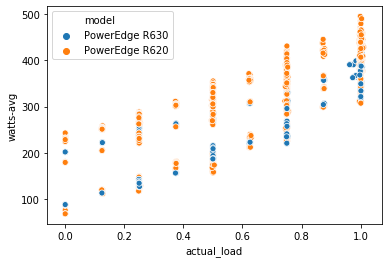

In [5]:
import seaborn as sns

cpu = full_details[(full_details['workload'] == 'CPU')| (full_details['workload'] == 'Idle')]
cpu = cpu[cpu['cpu'].str.contains('2690')]

sns.scatterplot('actual_load', 'watts-avg', hue='model', data=cpu)

# CPU Power

The CPU is usually considered the driver of most power consumption in the server (excluding any expansion cards). During the SERT tests we have also recorded low-level performance registers of the CPU like per-core frequency and also power consumption. 

Todo: 
- Add CPU power and frequency data to runs
- Determine relationship between chassis and CPU power consumption
    - Assume power = P_Idle + P_Chassis + P_CPU
    - IS P_Chassis a function of CPU power?

In [56]:
cpu_metrics = pd.DataFrame()

for f in glob.glob(f'{cpu_metrics_dir}//**.csv', recursive=True):
#     try:
    samples = pd.read_csv(f, skiprows=8, header=0, index_col=0, parse_dates=['Time'], encoding='cp1252')
    if not pd.api.types.is_datetime64_any_dtype(samples.index.dtype):
        # Final row contains "Session end:"
        samples.drop('Session end:', inplace=True)
        samples.index = pd.to_datetime(samples.index)
    
    cpu_metrics = cpu_metrics.append(samples)
#     except:
#         print(f'FAILED LOADING FILE: {f}')
    
cpu_metrics.sort_index(inplace=True)
cpu_metrics['total cpu power'] = cpu_metrics['CPU 0 Power'] + cpu_metrics['CPU 1 Power']

In [68]:
#pd.to_datetime(cpu_metrics['Time']
full_details['cpu_power'] = full_details.apply(lambda row: cpu_metrics['total cpu power'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
full_details['chassis_power'] = full_details['watts-avg'] - full_details['cpu_power']

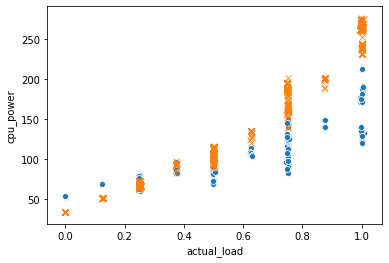

In [89]:
#full_details['chassis_power'].describe()

cpu = full_details[(full_details['workload'] == 'CPU')| (full_details['workload'] == 'Idle')]
cpu = cpu[cpu['bios'] == 'Efficiency']
cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]
cpu['bios'].describe()

sns.scatterplot('actual_load', 'chassis_power', data=cpu)
sns.scatterplot('actual_load', 'cpu_power', data=cpu, marker='x')